# Diabetes Clinical Dataset 

## About the Dataset (from [kaggle](https://www.kaggle.com/datasets/priyamchoksi/100000-diabetes-clinical-dataset/data))
Detailed dataset comprising health and demographic data of 100,000 individuals, aimed at facilitating diabetes-related research and predictive modeling. This dataset includes information on gender, age, location, race, hypertension, heart disease, smoking history, BMI, HbA1c level, blood glucose level, and diabetes status.

Dataset Use Cases
This dataset can be used for various analytical and machine learning purposes, such as:

Predictive Modeling: Build models to predict the likelihood of diabetes based on demographic and health-related features.
Health Analytics: Analyze the correlation between different health metrics (e.g., BMI, HbA1c level) and diabetes.
Demographic Studies: Examine the distribution of diabetes across different demographic groups and locations.
Public Health Research: Identify risk factors for diabetes and target interventions to high-risk groups.
Clinical Research: Study the relationship between comorbid conditions like hypertension and heart disease with diabetes.

In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats.mstats import winsorize
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, mean_absolute_error, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import warnings
import nbconvert
warnings.filterwarnings(action="ignore")

In [493]:
diabetes_df = pd.read_csv('diabetes_dataset.csv')
diabetes_df.info()
diabetes_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,Female,33.0,Wyoming,0,0,0,0,1,0,0,never,21.21,6.5,90,0
99996,2016,Female,80.0,Wyoming,0,1,0,0,0,0,0,No Info,36.66,5.7,100,0
99997,2018,Male,46.0,Wyoming,0,1,0,0,0,0,0,ever,36.12,6.2,158,0
99998,2018,Female,51.0,Wyoming,1,0,0,0,0,0,0,not current,29.29,6.0,155,0


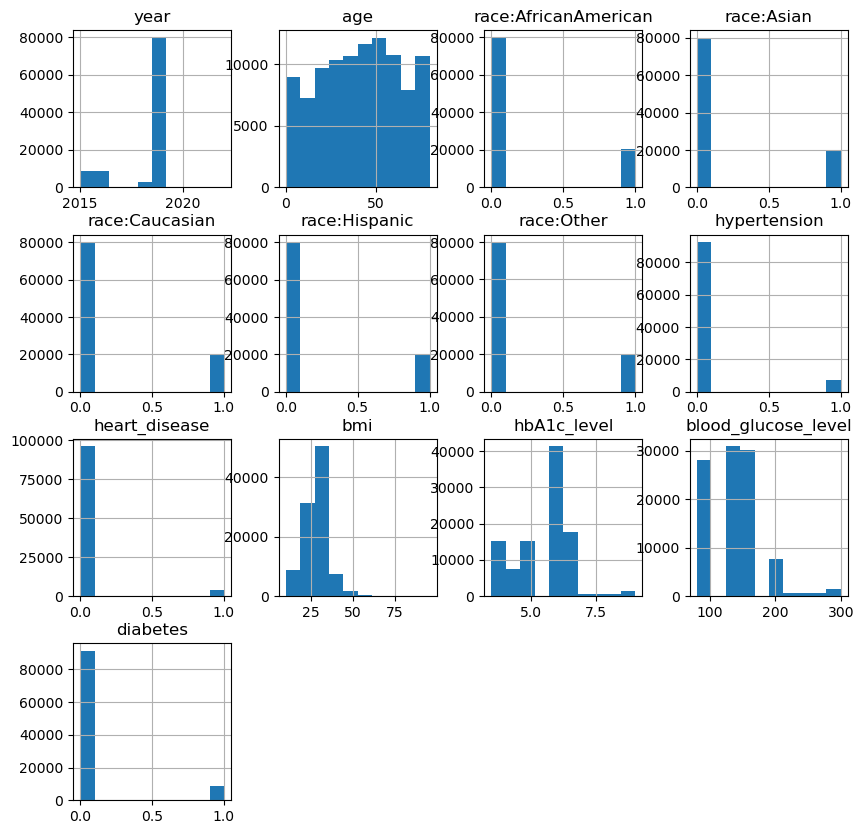

In [494]:
diabetes_df.hist(figsize=(10,10))
plt.show()

In [495]:
diabetes_df['gender'].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [496]:
diabetes_df_ym = diabetes_df.copy()
diabetes_df_ym.drop(diabetes_df_ym[diabetes_df_ym['gender'] == 'Other'].index, inplace=True)
diabetes_df_ym['gender'].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [497]:
diabetes_df_ym['is_male'] = pd.get_dummies(diabetes_df_ym['gender'], drop_first=True,dtype=int)
diabetes_df_ym.drop(['gender'],axis=1,inplace=True)
diabetes_df_ym.head()

,year,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,is_male
0,2020,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,0
1,2015,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,0
2,2015,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,1
3,2015,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,1
4,2016,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,0


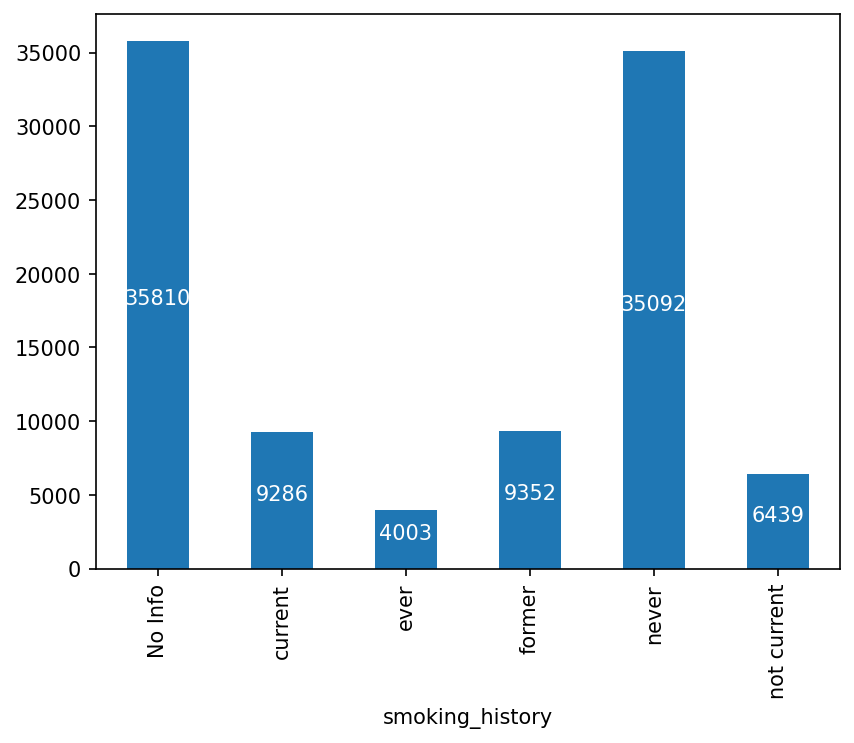

In [498]:

x_labels = diabetes_df_ym['smoking_history'].unique()
y_labels = diabetes_df_ym.groupby(['smoking_history'])['smoking_history'].count().values.tolist()

plt.figure(dpi=150)
diabetes_df_ym.groupby(['smoking_history'])['smoking_history'].count().plot(kind='bar')

for i in range(len(x_labels)):
        plt.text(i,y_labels[i]//2,y_labels[i], ha='center', color='w')

#plt.grid(axis='both', color='0.95')
plt.show()

In [499]:
#from sklearn.preprocessing import OneHotEncoder

#ohe = OneHotEncoder(sparse_output=False) 

#smoking_his_ohe = ohe.fit_transform(diabetes_df[['smoking_history']]) # It returns an numpy array
#smoking_his_ohe[:12]'''

In [500]:
#smoking_df = pd.DataFrame(smoking_his_ohe,columns=le_smoking_history.classes_)
#smoking_df

In [501]:
smoking_classes_df = pd.concat([diabetes_df_ym,
                             pd.get_dummies(diabetes_df_ym['smoking_history'],dtype=int, prefix='smk_hist')], 
                            axis=1)
smoking_classes_df

,year,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,...,hbA1c_level,blood_glucose_level,diabetes,is_male,smk_hist_No Info,smk_hist_current,smk_hist_ever,smk_hist_former,smk_hist_never,smk_hist_not current
0,2020,32.0,Alabama,0,0,0,0,1,0,0,...,5.0,100,0,0,0,0,0,0,1,0
1,2015,29.0,Alabama,0,1,0,0,0,0,0,...,5.0,90,0,0,0,0,0,0,1,0
2,2015,18.0,Alabama,0,0,0,0,1,0,0,...,4.8,160,0,1,0,0,0,0,1,0
3,2015,41.0,Alabama,0,0,1,0,0,0,0,...,4.0,159,0,1,0,0,0,0,1,0
4,2016,52.0,Alabama,1,0,0,0,0,0,0,...,6.5,90,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,33.0,Wyoming,0,0,0,0,1,0,0,...,6.5,90,0,0,0,0,0,0,1,0
99996,2016,80.0,Wyoming,0,1,0,0,0,0,0,...,5.7,100,0,0,1,0,0,0,0,0
99997,2018,46.0,Wyoming,0,1,0,0,0,0,0,...,6.2,158,0,1,0,0,1,0,0,0
99998,2018,51.0,Wyoming,1,0,0,0,0,0,0,...,6.0,155,0,0,0,0,0,0,0,1


<Axes: >

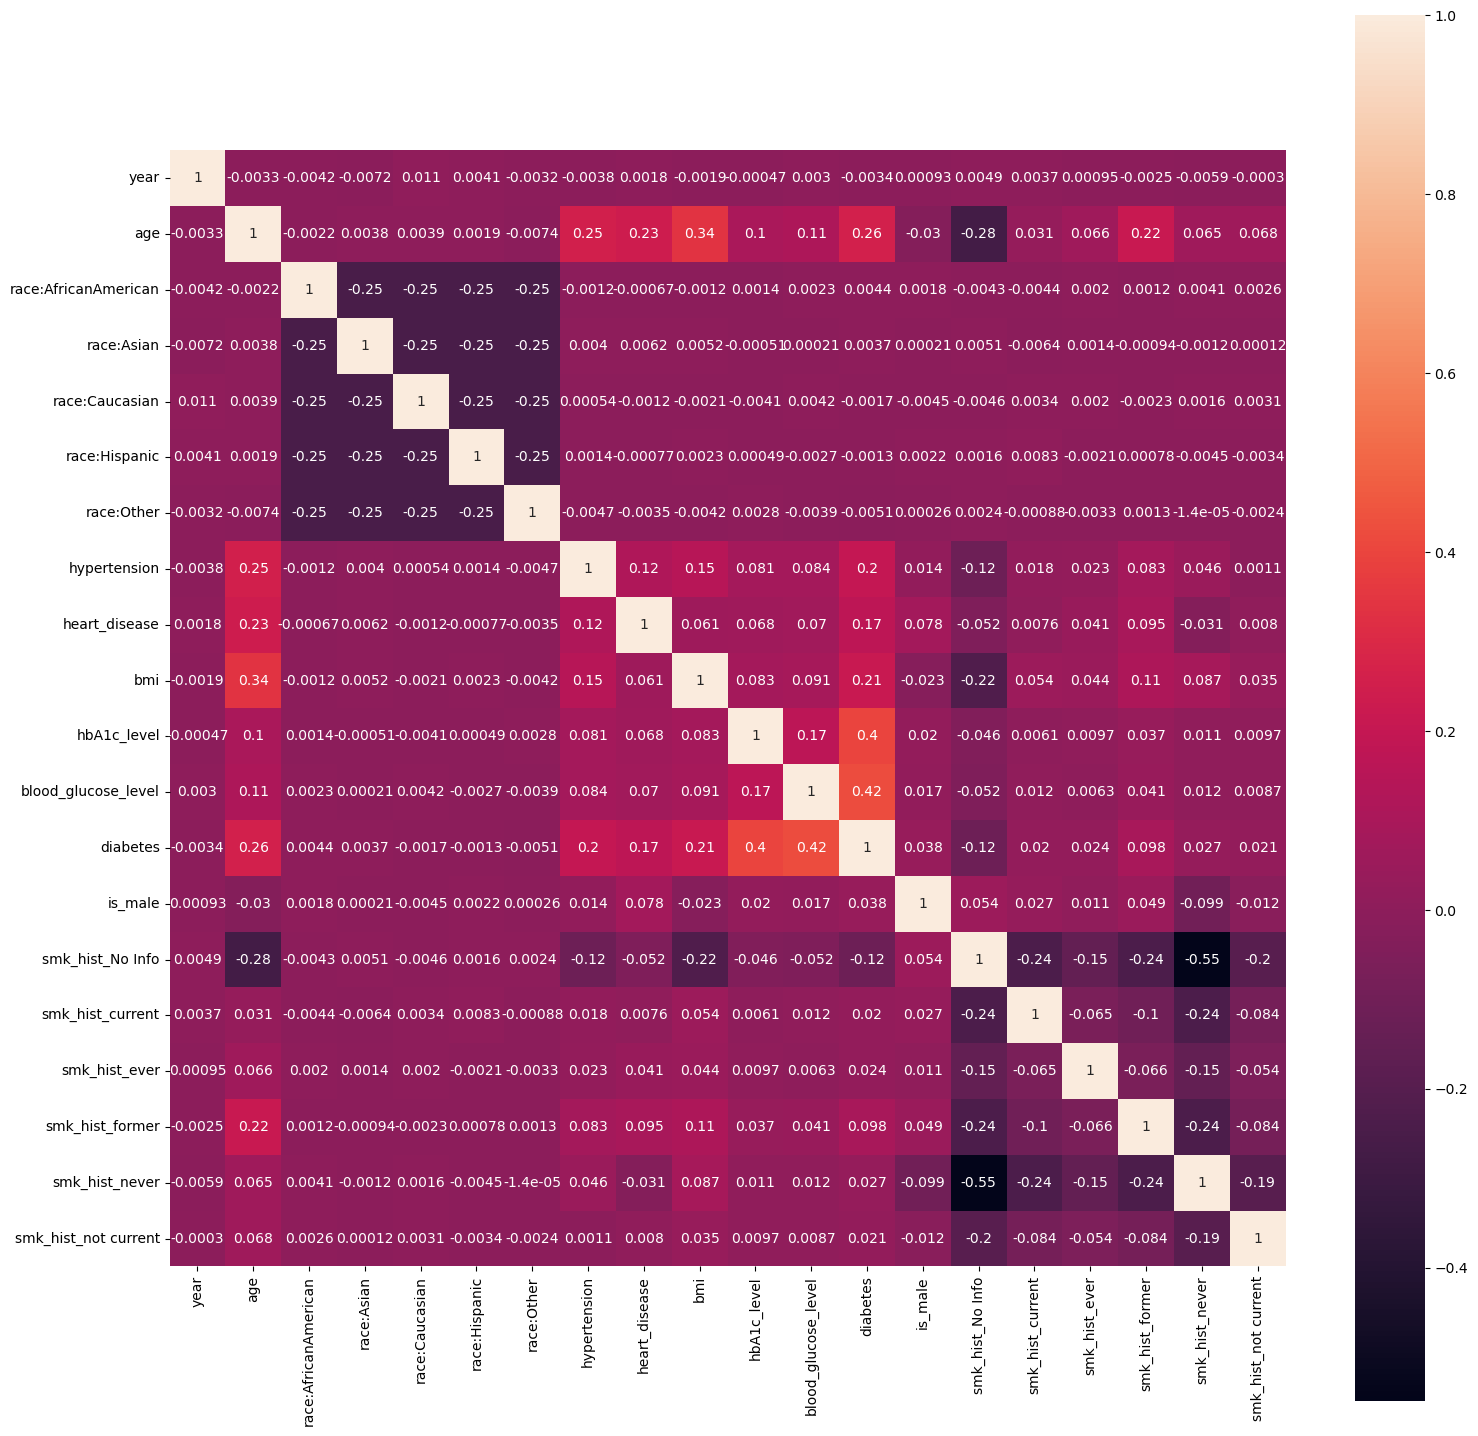

In [502]:
plt.figure(figsize=(18,18))
sns.heatmap(smoking_classes_df.loc[:, ~smoking_classes_df.columns.isin(['location', 'location_num','smoking_history','smoking_history_num'])].corr(), square=True, annot=True)

In [503]:
from sklearn.preprocessing import LabelEncoder

le_location = LabelEncoder()
le_smoking_history  = LabelEncoder()

diabetes_df_ym['location_num'] = le_location.fit_transform(diabetes_df_ym['location'])
diabetes_df_ym['smoking_history_num'] = le_smoking_history.fit_transform(diabetes_df_ym['smoking_history'])

In [504]:
diabetes_df_ym

,year,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,is_male,location_num,smoking_history_num
0,2020,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,0,0,4
1,2015,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,0,0,4
2,2015,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,1,0,4
3,2015,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,1,0,4
4,2016,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,33.0,Wyoming,0,0,0,0,1,0,0,never,21.21,6.5,90,0,0,54,4
99996,2016,80.0,Wyoming,0,1,0,0,0,0,0,No Info,36.66,5.7,100,0,0,54,0
99997,2018,46.0,Wyoming,0,1,0,0,0,0,0,ever,36.12,6.2,158,0,1,54,2
99998,2018,51.0,Wyoming,1,0,0,0,0,0,0,not current,29.29,6.0,155,0,0,54,5


In [505]:
diabetes_df_ym.drop(['location','smoking_history'], axis=1, inplace=True)
diabetes_df_ym

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,is_male,location_num,smoking_history_num
0,2020,32.0,0,0,0,0,1,0,0,27.32,5.0,100,0,0,0,4
1,2015,29.0,0,1,0,0,0,0,0,19.95,5.0,90,0,0,0,4
2,2015,18.0,0,0,0,0,1,0,0,23.76,4.8,160,0,1,0,4
3,2015,41.0,0,0,1,0,0,0,0,27.32,4.0,159,0,1,0,4
4,2016,52.0,1,0,0,0,0,0,0,23.75,6.5,90,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2018,33.0,0,0,0,0,1,0,0,21.21,6.5,90,0,0,54,4
99996,2016,80.0,0,1,0,0,0,0,0,36.66,5.7,100,0,0,54,0
99997,2018,46.0,0,1,0,0,0,0,0,36.12,6.2,158,0,1,54,2
99998,2018,51.0,1,0,0,0,0,0,0,29.29,6.0,155,0,0,54,5


In [506]:
diabetes_df_ym.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,is_male,location_num,smoking_history_num
count,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000,99982.000000
mean,2018.360745,41.888076,0.202246,0.200166,0.198706,0.198886,0.199996,0.074863,0.039427,27.320757,5.527529,138.057810,0.085015,0.414375,24.749805,2.179502
std,1.345292,22.517206,0.401677,0.400126,0.399028,0.399164,0.399999,0.263172,0.194610,6.636853,1.070665,40.709469,0.278906,0.492616,14.786141,1.889559
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000,0.000000,0.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.630000,4.800000,100.000000,0.000000,0.000000,12.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000,0.000000,25.000000,3.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.580000,6.200000,159.000000,0.000000,1.000000,37.000000,4.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000,1.000000,54.000000,5.000000


In [507]:
diabetes_df_ym.corr()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes,is_male,location_num,smoking_history_num
year,1.000000,-0.003300,-0.004213,-0.007220,0.010510,0.004146,-0.003168,-0.003791,0.001832,-0.001922,-0.000470,0.002966,-0.003448,0.000926,-0.062230,-0.006513
age,-0.003300,1.000000,-0.002203,0.003763,0.003910,0.001937,-0.007385,0.251163,0.233352,0.337378,0.101343,0.110679,0.257999,-0.030369,0.005341,0.228710
race:AfricanAmerican,-0.004213,-0.002203,1.000000,-0.251884,-0.250735,-0.250877,-0.251751,-0.001212,-0.000672,-0.001234,0.001361,0.002256,0.004366,0.001766,-0.002977,0.006158
race:Asian,-0.007220,0.003763,-0.251884,1.000000,-0.249118,-0.249258,-0.250127,0.003966,0.006158,0.005238,-0.000512,0.000205,0.003727,0.000209,0.000972,-0.002294
race:Caucasian,0.010510,0.003910,-0.250735,-0.249118,1.000000,-0.248121,-0.248985,0.000542,-0.001198,-0.002113,-0.004118,0.004161,-0.001707,-0.004497,-0.001945,0.003473
race:Hispanic,0.004146,0.001937,-0.250877,-0.249258,-0.248121,1.000000,-0.249126,0.001365,-0.000774,0.002347,0.000493,-0.002720,-0.001305,0.002246,0.004911,-0.005548
race:Other,-0.003168,-0.007385,-0.251751,-0.250127,-0.248985,-0.249126,1.000000,-0.004653,-0.003519,-0.004235,0.002761,-0.003908,-0.005107,0.000262,-0.000944,-0.001817
hypertension,-0.003791,0.251163,-0.001212,0.003966,0.000542,0.001365,-0.004653,1.000000,0.121253,0.147679,0.080941,0.084436,0.197811,0.014381,0.005698,0.093213
heart_disease,0.001832,0.233352,-0.000672,0.006158,-0.001198,-0.000774,-0.003519,0.121253,1.000000,0.061203,0.067591,0.070071,0.171718,0.077886,0.004370,0.027618
bmi,-0.001922,0.337378,-0.001234,0.005238,-0.002113,0.002347,-0.004235,0.147679,0.061203,1.000000,0.083017,0.091310,0.214377,-0.023023,-0.000235,0.179401


In [508]:
diabetes_df_ym.columns

Index(['year', 'age', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian',
       'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi',
       'hbA1c_level', 'blood_glucose_level', 'diabetes', 'is_male',
       'location_num', 'smoking_history_num'],
      dtype='object')

In [509]:
diabetes_df_ym = diabetes_df_ym[['year', 'age', 'is_male', 'location_num', 'race:AfricanAmerican', 'race:Asian', 'race:Caucasian',
       'race:Hispanic', 'race:Other', 'hypertension', 'heart_disease', 'bmi',
       'hbA1c_level', 'blood_glucose_level',
       'smoking_history_num', 'diabetes']]

<Axes: >

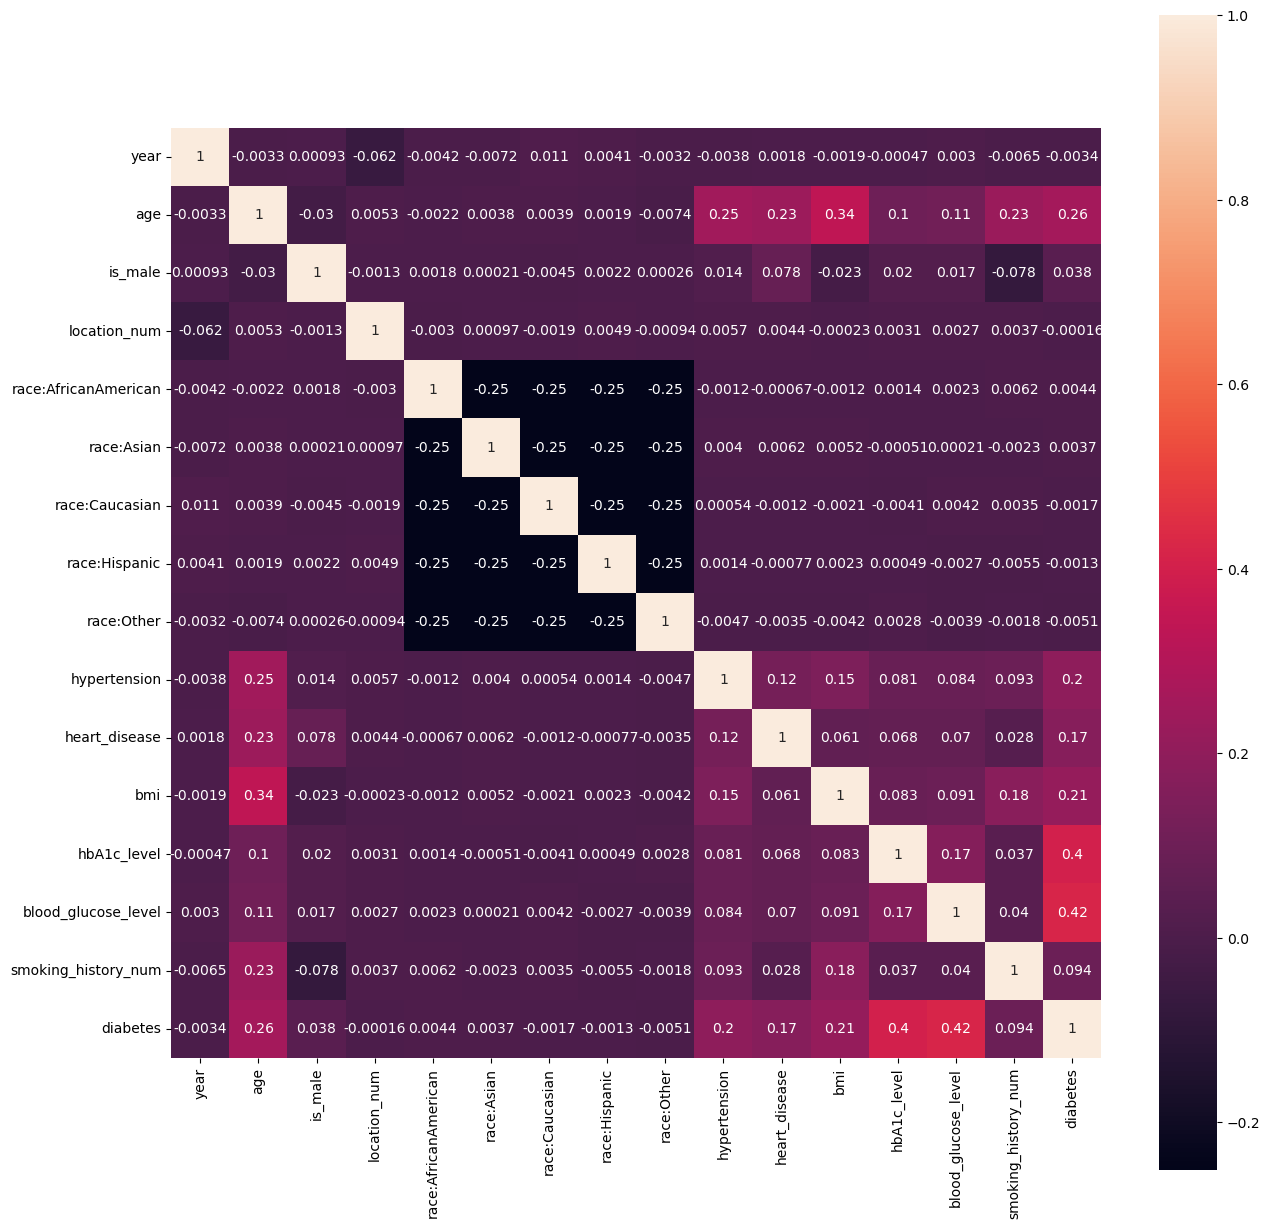

In [510]:
plt.figure(figsize=(15,15))
sns.heatmap(diabetes_df_ym.corr(),square=True, annot=True)

## Dealing with Outliers

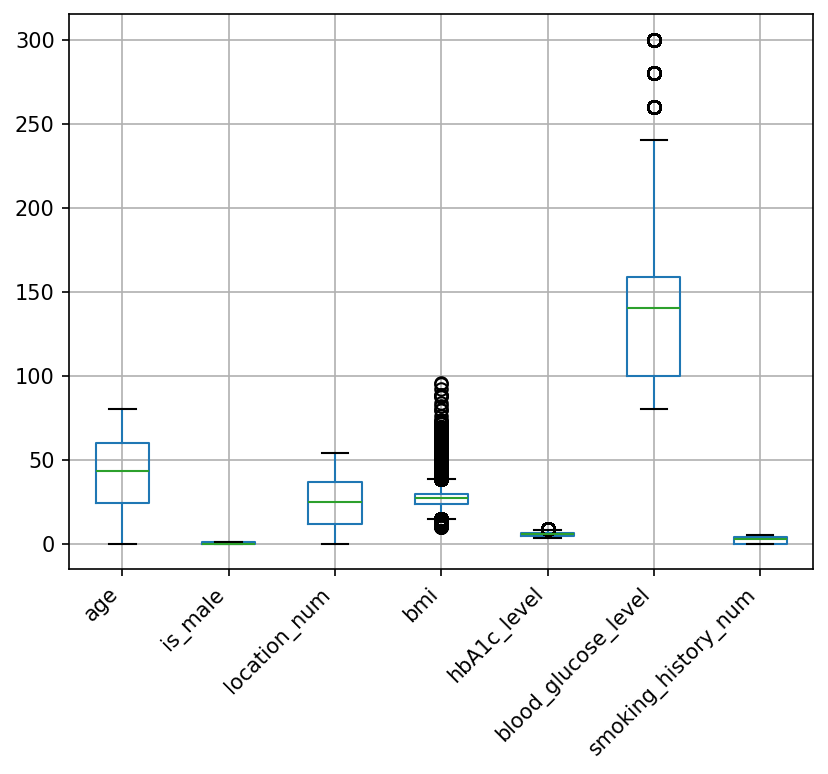

In [512]:
plt.figure(dpi=150)
diabetes_df_ym.loc[:, ~diabetes_df_ym.columns.isin(['year','race:AfricanAmerican',
       'race:Asian', 'race:Caucasian', 'race:Hispanic', 'race:Other',
       'hypertension', 'heart_disease','diabetes'])].boxplot()
plt.xticks(rotation=45,ha='right')
plt.show()

<Axes: >

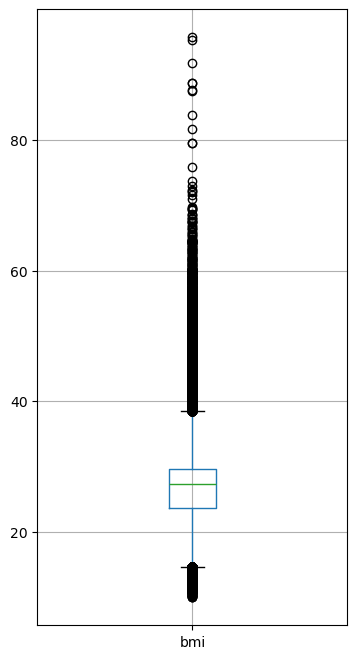

In [513]:
plt.figure(figsize=(4,8))
diabetes_df_ym[['bmi']].boxplot()

### Tukey’s test

In [515]:
q75, q25 = np.percentile(diabetes_df_ym['bmi'], [75 ,25])
iqr = q75 - q25
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((diabetes_df_ym['bmi'] > max_val)
                      | (diabetes_df_ym['bmi'] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 16603
The score threshold is: 1.5
Number of outliers is: 7085
The score threshold is: 2.0
Number of outliers is: 3655
The score threshold is: 2.5
Number of outliers is: 2130
The score threshold is: 3.0
Number of outliers is: 1258
The score threshold is: 3.5
Number of outliers is: 705
The score threshold is: 4.0
Number of outliers is: 420
The score threshold is: 4.5
Number of outliers is: 246


### Log transformation

In [517]:
bmi_log = np.log(diabetes_df_ym['bmi'])

In [518]:
q75, q25 = np.percentile(bmi_log, [75 ,25])
iqr = q75 - q25
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((bmi_log > max_val)
                      | (bmi_log < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 17018
The score threshold is: 1.5
Number of outliers is: 8728
The score threshold is: 2.0
Number of outliers is: 3099
The score threshold is: 2.5
Number of outliers is: 887
The score threshold is: 3.0
Number of outliers is: 267
The score threshold is: 3.5
Number of outliers is: 64
The score threshold is: 4.0
Number of outliers is: 14
The score threshold is: 4.5
Number of outliers is: 9


### Winsorize cap

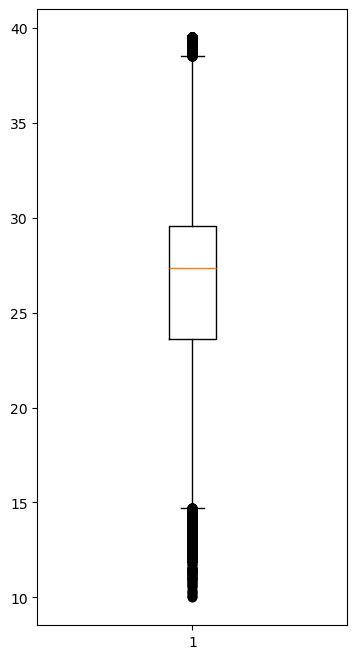

In [520]:
plt.figure(figsize=(4,8))
bmi_winsor = winsorize(diabetes_df_ym['bmi'], (0, 0.05))
plt.boxplot(bmi_winsor)
plt.show()

In [521]:
# Tuky's test for bmi_winsor
q75, q25 = np.percentile(bmi_winsor, [75 ,25])
iqr = q75 - q25
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((bmi_winsor > max_val)
                      | (bmi_winsor < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 16603
The score threshold is: 1.5
Number of outliers is: 7085
The score threshold is: 2.0
Number of outliers is: 62
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


In [522]:
diabetes_df_ym['bmi'] = bmi_winsor

In [523]:
# Tuky's test for blood_glucose_level

q75, q25 = np.percentile(diabetes_df_ym['blood_glucose_level'], [75 ,25])
iqr = q75 - q25
for threshold in np.arange(1,5,0.5):
    min_val = q25 - (iqr*threshold)
    max_val = q75 + (iqr*threshold)
    print("The score threshold is: {}".format(threshold))
    print("Number of outliers is: {}".format(
        len((np.where((diabetes_df_ym['blood_glucose_level'] > max_val)
                      | (diabetes_df_ym['blood_glucose_level'] < min_val))[0]))
    ))

The score threshold is: 1.0
Number of outliers is: 3277
The score threshold is: 1.5
Number of outliers is: 2038
The score threshold is: 2.0
Number of outliers is: 1403
The score threshold is: 2.5
Number of outliers is: 0
The score threshold is: 3.0
Number of outliers is: 0
The score threshold is: 3.5
Number of outliers is: 0
The score threshold is: 4.0
Number of outliers is: 0
The score threshold is: 4.5
Number of outliers is: 0


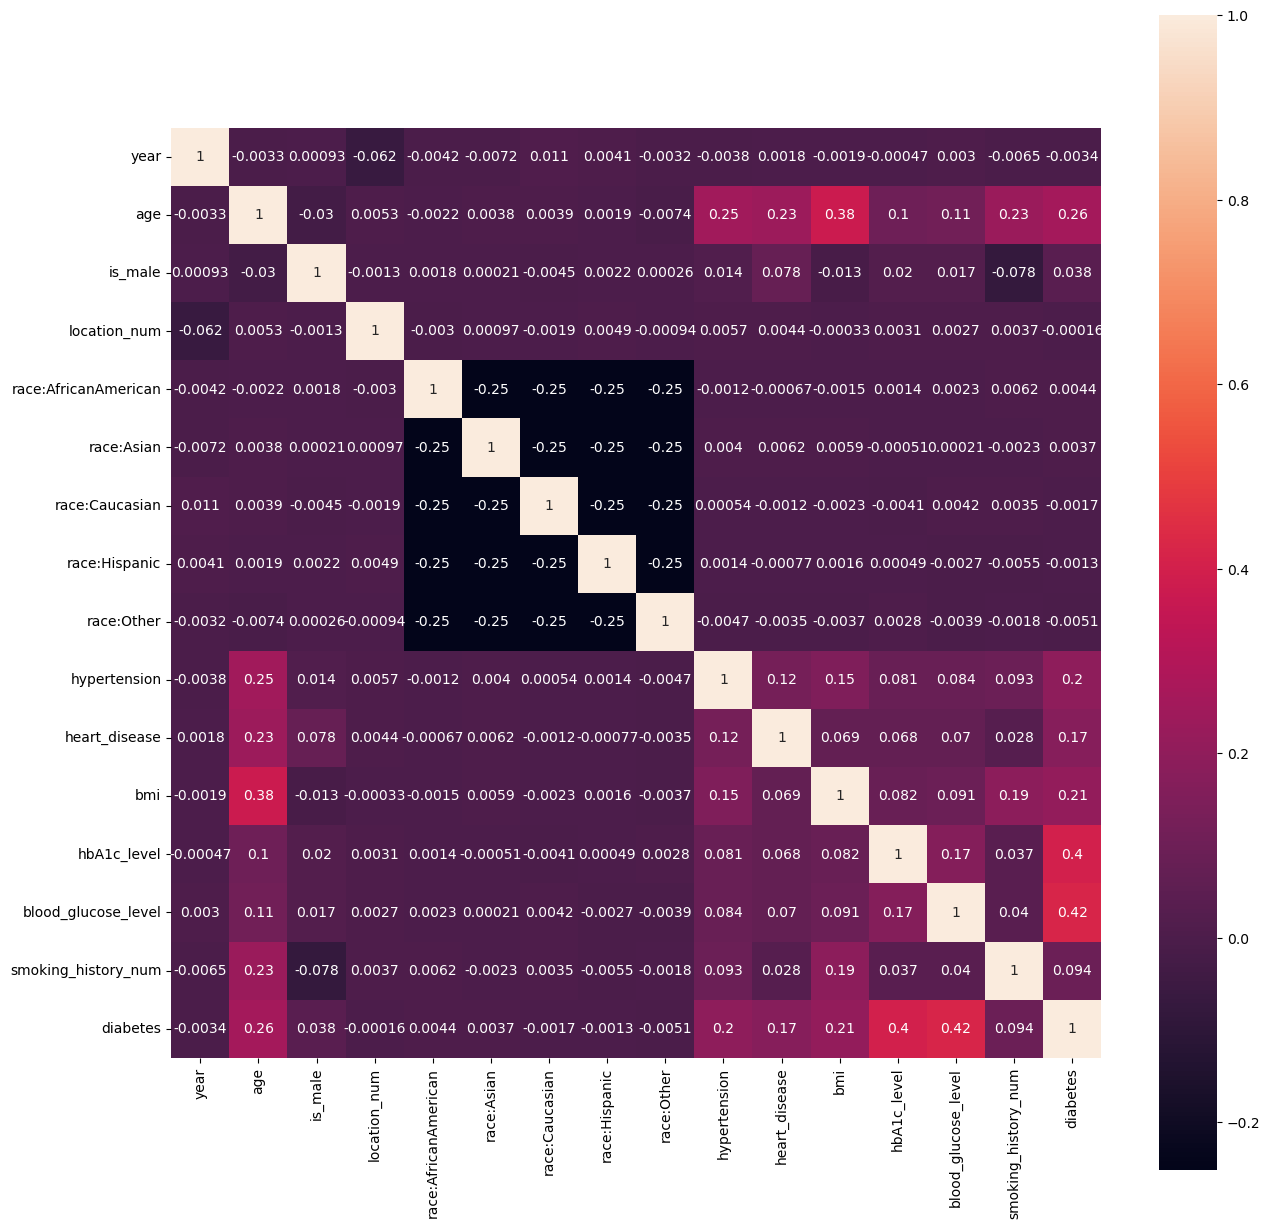

In [524]:
plt.figure(figsize=(15,15))
sns.heatmap(diabetes_df_ym.corr(),annot=True, square=True)
plt.show()

In [525]:
diabetes_df_ym['smoking_history_num'].value_counts()

smoking_history_num
0    35810
4    35092
3     9352
1     9286
5     6439
2     4003
Name: count, dtype: int64

In [556]:
diabetes_df['smoking_history'].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

---
---
# Models
---
---

Based on the data analysis above, the most relevant features to the target feature `diabetes` are:
- age
- hypertension
- heart_disease
- bmi
- hbA1c_level
- blood_glucose_level
- smoking_history_num

In [558]:
X = diabetes_df_ym[['age','hypertension','heart_disease','bmi','hbA1c_level','blood_glucose_level', 'smoking_history_num']]
Y = diabetes_df_ym['diabetes']

### Logistic Regression

In [560]:
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2, random_state = 456)

lr = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state = 2)
lr.fit(X_train,y_train)

lr_score = lr.score(X_test,y_test)
lr_score_train = lr.score(X_train,y_train)
lr_prediction = lr.predict(X_test)

print('Accuracy of test score = {}'.format(lr_score))
print('Accuracy of train score = {}'.format(lr_score_train))

Accuracy of test score = 0.9610941641246187
Accuracy of train score = 0.9601675314121397


Since the training score is lower than the test score, the posibility of overfitting is unlikely.

In [562]:
lr.predict_proba(X_test)[:,1]

array([2.23718958e-04, 9.77171437e-05, 1.29626306e-05, ...,
       1.47232594e-03, 5.23118422e-02, 1.63560856e-05])

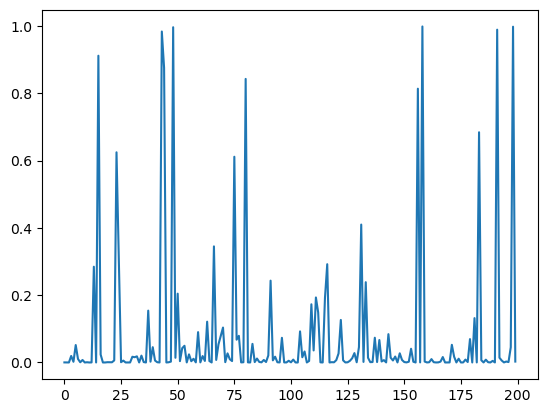

In [564]:
plt.plot(lr.predict_proba(X_test)[:200,1])

#### Evaluation of model: Confusion matrix plot

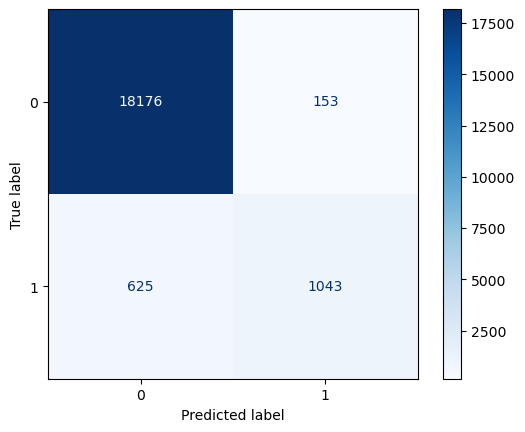

In [570]:
lr_predictions = lr.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, lr_predictions, cmap=plt.cm.Blues)
plt.show()

In [572]:
print('Classification Report of the Logistic Regression model','\n\n',
      classification_report(y_test, lr_predictions))

Classification Report of the Logistic Regression model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18329
           1       0.87      0.63      0.73      1668

    accuracy                           0.96     19997
   macro avg       0.92      0.81      0.85     19997
weighted avg       0.96      0.96      0.96     19997



### Decision Tree

In [51]:
from IPython.display import Image
import pydotplus
import graphviz

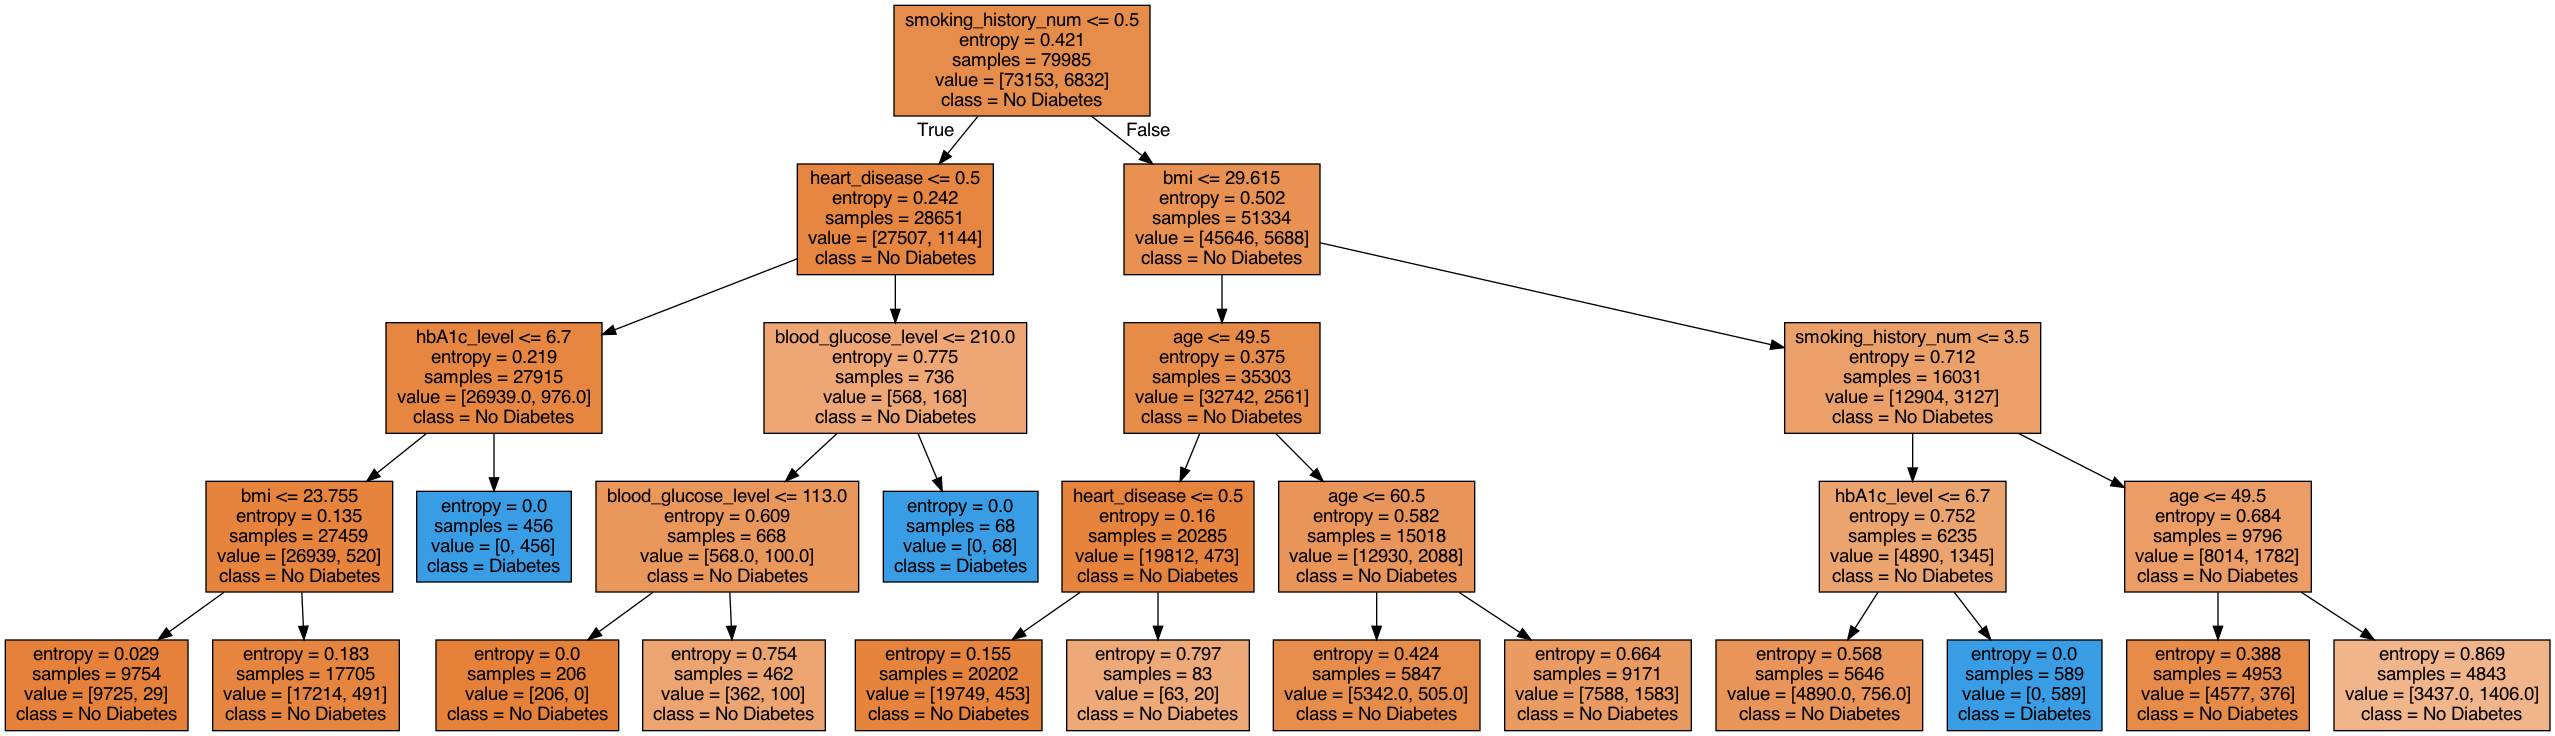

In [476]:
# Initialize and train the tree

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    random_state = 1337
)

decision_tree.fit(X_train, y_train)
# Render the tree
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X_train.columns,
    class_names=['No Diabetes', 'Diabetes'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [478]:
tree_test_accuracy = decision_tree.score(X_test,y_test)
tree_preds = decision_tree.predict(X_test)

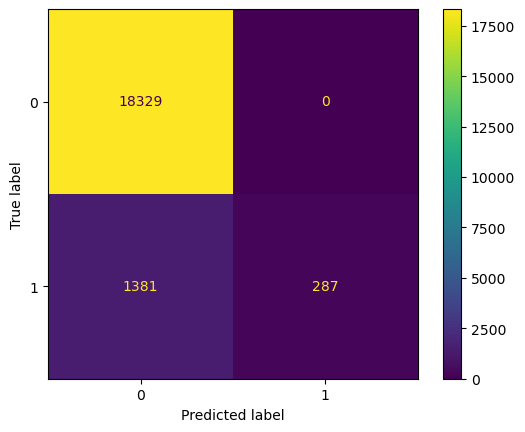

In [480]:
ConfusionMatrixDisplay.from_predictions(y_test, tree_preds)
plt.show()

In [574]:
print('Classification Report of the Decision Tree model','\n\n',
      classification_report(y_test, tree_preds))

Classification Report of the Decision Tree model 

               precision    recall  f1-score   support

           0       0.93      1.00      0.96     18329
           1       1.00      0.17      0.29      1668

    accuracy                           0.93     19997
   macro avg       0.96      0.59      0.63     19997
weighted avg       0.94      0.93      0.91     19997



### Random Forest

In [53]:
rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
print(f'{cross_val_score(rfc, X_train, y_train, cv=10)}\n')

[0.96974622 0.96612077 0.9656207  0.96912114 0.96899612 0.96974244
 0.9696174  0.96874219 0.96849212 0.97024256]



In [57]:
rfc.fit(X_train,y_train)

accuracy_rfc_train = rfc.score(X_train,y_train)
accuracy_rfc_test = rfc.score(X_test,y_test)

print('Accuracy of train score = {}'.format(accuracy_rfc_train))
print('Accuracy of test score = {}'.format(accuracy_rfc_test))

Accuracy of train score = 0.9938738513471276
Accuracy of test score = 0.9687453117967695


#### Evaluation of model: Confusion matrix plot

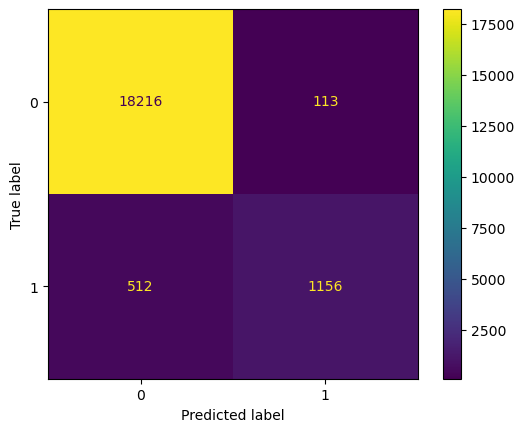

Recall score = 0.6930455635491607


In [576]:
rfc_preds = rfc.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, rfc_preds)
plt.show()

print('Recall score = {}'.format(recall_score(y_test,rfc_preds)))

In [578]:
print('Classification Report of the Random Forest model','\n\n',
      classification_report(y_test, rfc_preds))

Classification Report of the Random Forest model 

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18329
           1       0.91      0.69      0.79      1668

    accuracy                           0.97     19997
   macro avg       0.94      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



### Support Vector Machine

In [580]:
svm = SVC(kernel = 'linear')
svm.fit(X_train,y_train)

SVC(kernel='linear')

In [582]:
svm.predict(X_test)
accuracy_train = svm.score(X_train, y_train)
accuracy_test = svm.score(X_test, y_test)

print('Accuracy of train score = {}'.format(accuracy_train))
print('Accuracy of test score = {}'.format(accuracy_test))

Accuracy of train score = 0.9598174657748327
Accuracy of test score = 0.9605440816122418


#### Evaluation of model: Confusion matrix plot

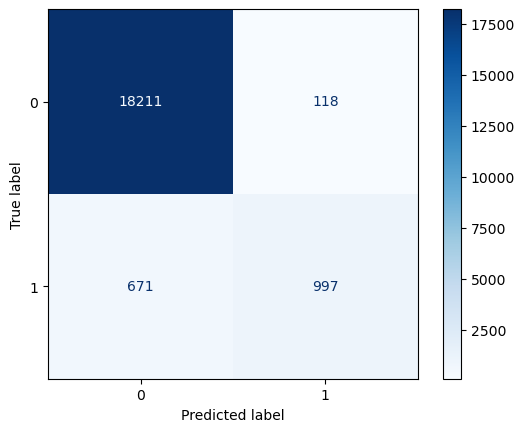

Recall score = 0.5977218225419664


In [588]:
svm_preds = svm.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, svm_preds, cmap=plt.cm.Blues)
plt.show()

print('Recall score = {}'.format(recall_score(y_test,svm_preds)))

In [590]:
print('Classification Report of the SVM model','\n\n',classification_report(y_test, svm_preds))

Classification Report of the SVM model 

               precision    recall  f1-score   support

           0       0.96      0.99      0.98     18329
           1       0.89      0.60      0.72      1668

    accuracy                           0.96     19997
   macro avg       0.93      0.80      0.85     19997
weighted avg       0.96      0.96      0.96     19997



### Gradient Boosting

In [593]:
params = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'exponential',
         }

gbc = ensemble.GradientBoostingClassifier(**params)
gbc.fit(X_train,y_train)

gbc_preds_train = gbc.score(X_train, y_train)
gbc_preds_test = gbc.score(X_test, y_test)

print('Accuracy of train score = {}'.format(gbc_preds_train))
print('Accuracy of test score = {}'.format(gbc_preds_test))

Accuracy of train score = 0.9724698380946427
Accuracy of test score = 0.9723958593789068


#### Evaluation of model: Confusion matrix plot

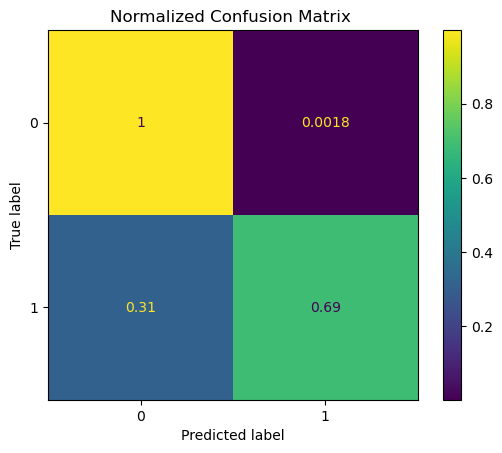

In [624]:
gbc_preds = gbc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, gbc_preds, normalize='true')
plt.title('Normalized Confusion Matrix ')
plt.show()

In [597]:
print('Accuracy score = {}'.format(gbc_preds_test))

print('Precision score = {}'.format(precision_score(y_test,gbc_preds)))

print('Recall score = {}'.format(recall_score(y_test,gbc_preds)))

Accuracy score = 0.9723958593789068
Precision score = 0.9720812182741116
Recall score = 0.6888489208633094


In [599]:
print('Classification Report of the model','\n\n',classification_report(y_test, gbc_preds))

Classification Report of the model 

               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18329
           1       0.97      0.69      0.81      1668

    accuracy                           0.97     19997
   macro avg       0.97      0.84      0.90     19997
weighted avg       0.97      0.97      0.97     19997



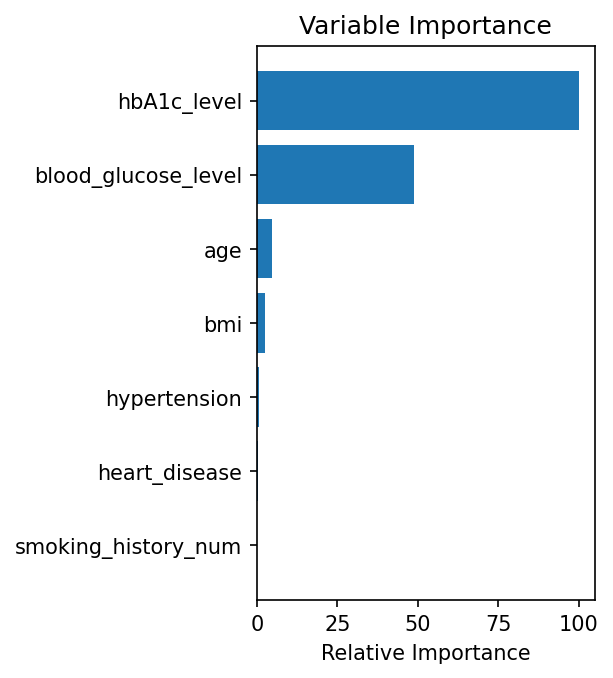

In [605]:
feature_importance = gbc.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(dpi=150)
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

It appears that `hbA1c_level` and `blood_glucose_level` are the most important features in predicting whether or not someone has diabetes.

#### Gradient Booster with modified parameters

In [608]:
params_mod = {'n_estimators': 1000,
          'max_depth': 2,
          'loss': 'log_loss',
         }

gbc1 = ensemble.GradientBoostingClassifier(**params_mod)
gbc1.fit(X_train,y_train)

gbc1_preds_train = gbc1.score(X_train, y_train)
gbc1_preds_test = gbc1.score(X_test, y_test)

print('Accuracy of train score = {}'.format(gbc1_preds_train))
print('Accuracy of test score = {}'.format(gbc1_preds_test))

Accuracy of train score = 0.9728074013877602
Accuracy of test score = 0.9719957993699054


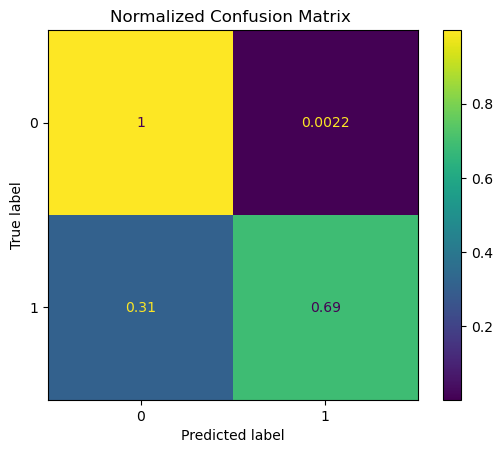

In [626]:
gbc1_preds = gbc1.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, gbc1_preds, normalize='true')
plt.title('Normalized Confusion Matrix ')
plt.show()

In [612]:
print('Accuracy score = {}'.format(gbc1_preds_test))

print('Precision score = {}'.format(precision_score(y_test,gbc1_preds)))

print('Recall score = {}'.format(recall_score(y_test,gbc1_preds)))

Accuracy score = 0.9719957993699054
Precision score = 0.965546218487395
Recall score = 0.6888489208633094


In [614]:
print('Classification Report of the modified model with log_loss','\n\n',classification_report(y_test, gbc1_preds))

Classification Report of the modified model with log_loss 

               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18329
           1       0.97      0.69      0.80      1668

    accuracy                           0.97     19997
   macro avg       0.97      0.84      0.89     19997
weighted avg       0.97      0.97      0.97     19997



## Evaluation and Conclusion

In [634]:
results_df = pd.DataFrame({'Model':['Logistic Regression','Decision Tree','Random Forest','SVM','Gradient Boosting (log_loss)','Gradient Boosting (exponential)'],
                           'Accuracy':[0.98,0.93,0.97,0.96,0.97,0.97],
                          'Precision':[0.87,1,0.91,0.89,0.97,0.97],
                          'Recall':[0.63,0.17,0.69,0.60,0.69,0.69],
                          'F-Score':[0.73,0.29,0.79,0.72,0.80,0.81]})
results_df

,Model,Accuracy,Precision,Recall,F-Score
0,Logistic Regression,0.98,0.87,0.63,0.73
1,Decision Tree,0.93,1.00,0.17,0.29
2,Random Forest,0.97,0.91,0.69,0.79
3,SVM,0.96,0.89,0.60,0.72
4,Gradient Boosting (log_loss),0.97,0.97,0.69,0.80
5,Gradient Boosting (exponential),0.97,0.97,0.69,0.81


Based on the score table of implemented  models, we can conclude that so far the `Gradient Boosting` model with loss function parameter set to `exponential` is the best-performing model.